In [329]:
import pathlib 
import glob
import pickle
import numpy as np
import ood_detectors.eval_utils as eval_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import create_latex_table, create_latex_table2, create_latex_table3, create_latex_table_mean


%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
results = {}
available = set()
for score_paths in map(pathlib.Path, glob.glob("results*/*_scores.pkl")):
    method, model = score_paths.stem.split("_", 1)
    parent = score_paths.parent.stem
    print(parent)
    available.add(method)
    model = model.replace("_scores", "")
    # print(model)
    if parent not in results:
        results[parent] = {}
    if model not in results[parent]:
        results[parent][model] = {}
    if method in results[parent]:
        raise ValueError(f"Duplicate method {method} for model {model}")
    with open(score_paths, "rb") as f:
        results[parent][model][method] = {
            'data': pickle.load(f),
            'src': model
            }

results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2
results_v2

In [331]:
available

{'Residual', 'VESDE', 'VPSDE', 'subVPSDE'}

In [332]:
def compute_scores(configs):
    scores = {}
    results = {}
    for experiment, encoder, method, dataset in configs:
        path = pathlib.Path(f"{experiment}/{method}_{dataset}_{encoder}_scores.pkl")
        if not path.exists():
            print(f"Missing {path}, {experiment}, {encoder}, {method}, {dataset}")
            return None
        with open(path, "rb") as f:
            scores[(experiment, encoder, method, dataset)] = pickle.load(f)
    score_id = None
    score_ref = None
    for key, value in scores.items():
        if 'score_id' not in value:
            print(f"Missing id score for {key}")
            return None
        if score_id is None:
            score_id = value['score_id']
        else:
            score_id += value['score_id']

        if 'score_ref' not in value:
            print(f"Missing ref score for {key}")
            return None
        if score_ref is None:
            score_ref = value['score_ref']
        else:
            score_ref += value['score_ref']
    
    score_id /= len(configs)
    score_ref /= len(configs)

    id_auc = eval_utils.auc(-score_ref, -score_id)
    id_fpr95 = eval_utils.fpr(-score_ref, -score_id)
    nearood_res = []

    if all(['nearood' in _type for _type in scores.values()]):
        names = []
        nearood = {}
        for _type, _dataset in scores.items():
            names.append([])
            for _name, _value in _dataset['nearood'].items():
                if _name not in nearood:
                    nearood[_name] = _value
                else:
                    nearood[_name] += _value
                names[-1].append(_name)
        if len(set(map(len, names))) != 1:
            print(f"Missing nearood for {key}, for {list(scores.values())}")
            return None
        for _name, value in nearood.items():
            score = value / len(configs)
            nearood_auc = eval_utils.auc(-score_ref, -score)
            nearood_fpr95 = eval_utils.fpr(-score_ref, -score)
            nearood_res.append( {
                'dataset': _name,
                'metrics': {
                    'score': np.mean(score),
                    'AUC': nearood_auc,
                    'FPR_95': nearood_fpr95
                }
            })

    farood_res = []
    if all(['farood' in _type for _type in scores.values()]):
        names = []
        farood = {}
        for _type, _dataset in scores.items():
            names.append([])
            for _name, _value in _dataset['farood'].items():
                if _name not in farood:
                    farood[_name] = _value
                else:
                    farood[_name] += _value
                names[-1].append(_name)
        if len(set(map(len, names))) != 1:
            print(f"Missing farood for {key}, for {list(scores.values())}")
            return None
        for _name, value in farood.items():
            score = value / len(configs)
            farood_auc = eval_utils.auc(-score_ref, -score)
            farood_fpr95 = eval_utils.fpr(-score_ref, -score)
            farood_res.append( {
                'dataset': _name,
                'metrics': {
                    'score': np.mean(score),
                    'AUC': farood_auc,
                    'FPR_95': farood_fpr95
                }
            })
    else:
        print(f"Missing nearood for {key}, for {list(scores.values())}")

    results = {
        'id': {
            'dataset': dataset,
            'metrics': {
                'AUC': id_auc,
                'FPR_95': id_fpr95,
                'score_id': np.mean(score_id),
                'score_ref': np.mean(score_ref)
            },
        },
        'nearood': nearood_res,
        'farood': farood_res,
    }
    return results

In [333]:
def print_scores(res):
    for k, v in res.items():
        print(k)
        if isinstance(v, dict):
            for _k, _v in v.items():
                # print(" ", _k)
                if isinstance(_v, dict):
                    for __k, __v in _v.items():
                        print(f'{__k}: {__v:.2f}', end=", ")
                else:
                    print(" ", _v,end=": ")
            print()
        elif isinstance(v, list):
            for _v in v:
                for _k, __v in _v.items():
                    # print(" ",_k)
                    if isinstance(__v, dict):
                        for __k, ___v in __v.items():
                            print(f'{__k}: {___v:.2f}', end=", ")
                    else:
                        print(" ",__v, end=": ")
                print()

In [372]:
experiments = ['results', 'results_v2', 'results_v3']
encoders = ['dino', 'dinov2', 'vit', 'clip', 'repvgg', 'resnet50d', 'swin', 'deit', 'swin_t', 'vit_b16', 'resnet18_32x32_cifar10_open_ood', 'resnet18_32x32_cifar100_open_ood', 'resnet18_224x224_imagenet200_open_ood', 'resnet50_224x224_imagenet_open_ood']
datasets = ['imagenet_sub','cifar10', 'cifar100', 'imagenet200', 'imagenet']

methods = ['subVPSDE', 'Residual', 'VESDE', 'VPSDE']
for encoder in ['dinov2', 'vit']:
    #'VESDE', 'VPSDE', 
    res = compute_scores([
        (experiments[1], encoder, 'subVPSDE', 'imagenet'), 
        (experiments[2], encoder, 'subVPSDE', 'imagenet'), 
        (experiments[1], encoder, 'VESDE', 'imagenet'), 
        (experiments[0], encoder, 'subVPSDE', 'imagenet'), 
        (experiments[1], encoder, 'VPSDE', 'imagenet'), 
        (experiments[2], encoder, 'VPSDE', 'imagenet'), 
        ])
    print_scores(res)
    print("*"*10)

id
  imagenet: AUC: 0.48, FPR_95: 0.96, score_id: 9.98, score_ref: 9.99, 
nearood
  imagenet-o: score: 10.37, AUC: 0.99, FPR_95: 0.01, 
  ninco: score: 10.43, AUC: 1.00, FPR_95: 0.00, 
  ssb_hard: score: 10.31, AUC: 0.96, FPR_95: 0.16, 
farood
  textures: score: 10.54, AUC: 1.00, FPR_95: 0.00, 
  openimageo: score: 10.57, AUC: 1.00, FPR_95: 0.00, 
  inaturalist: score: 10.71, AUC: 1.00, FPR_95: 0.00, 
**********
id
  imagenet: AUC: 0.44, FPR_95: 0.97, score_id: 196939360.00, score_ref: 11.07, 
nearood
  ssb_hard: score: 11.28, AUC: 0.97, FPR_95: 0.13, 
  ninco: score: 11.37, AUC: 0.99, FPR_95: 0.00, 
  imagenet-o: score: 11.34, AUC: 0.99, FPR_95: 0.00, 
farood
  textures: score: 11.38, AUC: 0.99, FPR_95: 0.00, 
  inaturalist: score: 11.47, AUC: 0.99, FPR_95: 0.00, 
  openimageo: score: 3145804544.00, AUC: 0.99, FPR_95: 0.00, 
**********


In [350]:
super_precompute = {}
for experiment in experiments:
    precompute = {}

    for method in methods:
        for encoder in encoders:
            for dataset in datasets:
                res = compute_scores([
                    (experiment, encoder, method, dataset),
                    ])
                method_name = method
                # if method == "subVPSDE":
                #     method_name = "RDM-OOD"
                if res is None:
                    continue
                if method_name not in precompute:
                    precompute[method_name] = {}
                if encoder not in precompute[method_name]:
                    precompute[method_name][encoder] = {}
                if dataset not in precompute[method_name][encoder]:
                    precompute[method_name][encoder][dataset] = res
                else:
                    raise ValueError(f"{method_name}, {encoder}, {dataset}, already exists")
        if method == "Residual":
            continue
        for encoder in encoders:
            for dataset in datasets:
                res = compute_scores([
                    (experiments[1], encoder, method, dataset),
                    (experiments[2], encoder, method, dataset),
                    ])
                method_name = f"{method}x2"
                if method == "subVPSDE":
                    method_name = "RDM-OODx2"
                if res is None:
                    continue
                if method_name not in precompute:
                    precompute[method_name] = {}
                if encoder not in precompute[method_name]:
                    precompute[method_name][encoder] = {}
                if dataset not in precompute[method_name][encoder]:
                    precompute[method_name][encoder][dataset] = res
                else:
                    raise ValueError(f"{method_name}, {encoder}, {dataset}, already exists")
    for encoder in encoders:
        for dataset in ['imagenet_sub', 'imagenet200', 'imagenet']:
            res = compute_scores([
                (experiments[1], encoder, "subVPSDE", dataset),
                (experiments[2], encoder, "subVPSDE", dataset),
                (experiments[1], encoder, "VPSDE", dataset),
                (experiments[2], encoder, "VPSDE", dataset),
                (experiments[1], encoder, "VESDE", dataset),
                (experiments[2], encoder, "VESDE", dataset),
                ])

            method_name = "RDM-OODx6"
            if res is None:
                continue
            if method_name not in precompute:
                precompute[method_name] = {}
            if encoder not in precompute[method_name]:
                precompute[method_name][encoder] = {}
            if dataset not in precompute[method_name][encoder]:
                precompute[method_name][encoder][dataset] = res
            else:
                raise ValueError(f"{method_name}, {encoder}, {dataset}, already exists")
    super_precompute[experiment] = precompute


            



Missing results/subVPSDE_cifar10_dino_scores.pkl, results, dino, subVPSDE, cifar10
Missing results/subVPSDE_cifar100_dino_scores.pkl, results, dino, subVPSDE, cifar100
Missing results/subVPSDE_cifar10_dinov2_scores.pkl, results, dinov2, subVPSDE, cifar10
Missing results/subVPSDE_cifar100_dinov2_scores.pkl, results, dinov2, subVPSDE, cifar100
Missing results/subVPSDE_cifar10_vit_scores.pkl, results, vit, subVPSDE, cifar10
Missing results/subVPSDE_cifar100_vit_scores.pkl, results, vit, subVPSDE, cifar100
Missing results/subVPSDE_imagenet_sub_clip_scores.pkl, results, clip, subVPSDE, imagenet_sub
Missing results/subVPSDE_cifar10_clip_scores.pkl, results, clip, subVPSDE, cifar10
Missing results/subVPSDE_cifar100_clip_scores.pkl, results, clip, subVPSDE, cifar100
Missing results/subVPSDE_cifar10_repvgg_scores.pkl, results, repvgg, subVPSDE, cifar10
Missing results/subVPSDE_cifar100_repvgg_scores.pkl, results, repvgg, subVPSDE, cifar100
Missing results/subVPSDE_cifar10_resnet50d_scores.pkl, 

In [352]:
super_precompute['results'].keys()

dict_keys(['subVPSDE', 'RDM-OODx2', 'Residual', 'VESDE', 'VESDEx2', 'VPSDE', 'VPSDEx2', 'RDM-OODx6'])

In [357]:
with open("out_v2.txt", "w") as f:
    for dataset in datasets:
        f.write(create_latex_table_mean(super_precompute,'subVPSDE', dataset, encoders))
    for method, result in precompute.items():
        for dataset in datasets:
            if method not in ['subVPSDE', 'VESDE', 'VPSDE']:
                f.write(create_latex_table(precompute, method, dataset, encoders))

In [324]:
names = ["Training",	"Post-processor",	"SSB-hard",	"NINCO",	"Near-OOD",	"iNaturalist",	"Textures",	"OpenImage-O",	"Far-OOD",	"ID ACC"]
data_auc = [
["CrossEntropy",	"OpenMax",	    71.37,	78.17,	74.77,	92.05,	88.10,	87.62,	89.26,	76.18],
["CrossEntropy",	"MSP",	        72.09,	79.95,	76.02,	88.41,	82.43,	84.86,	85.23,	76.18],
["CrossEntropy",	"TempScale",	72.87,	81.41,	77.14,	90.50,	84.95,	87.22,	87.56,	76.18],
["CrossEntropy",	"ODIN",	        71.74,	77.77,	74.75,	91.17,	89.00,	88.23,	89.47,	76.18],
["CrossEntropy",	"MDS",	        48.50,	62.38,	55.44,	63.67,	89.80,	69.27,	74.25,	76.18],
["CrossEntropy",	"MDSEns",	    43.92,	55.41,	49.67,	61.82,	79.94,	60.80,	67.52,	76.18],
["CrossEntropy",	"RMDS",	        71.77,	82.22,	76.99,	87.24,	86.08,	85.84,	86.38,	76.18],
["CrossEntropy",	"Gram",	        57.39,	66.01,	61.70,	76.67,	88.02,	74.43,	79.71,	76.18],
["CrossEntropy",	"EBO",	        72.08,	79.70,	75.89,	90.63,	88.70,	89.06,	89.47,	76.18],
["CrossEntropy",	"GradNorm",	    71.90,	74.02,	72.96,	93.89,	92.05,	84.82,	90.25,	76.18],
["CrossEntropy",	"ReAct",	    73.03,	81.73,	77.38,	96.34,	92.79,	91.87,	93.67,	76.18],
["CrossEntropy",	"MLS",	        72.51,	80.41,	76.46,	91.17,	88.39,	89.17,	89.57,	76.18],
["CrossEntropy",	"KLM",	        71.38,	81.90,	76.64,	90.78,	84.72,	87.30,	87.60,	76.18],
["CrossEntropy",	"VIM",	        65.54,	78.63,	72.08,	89.56,	97.97,	90.50,	92.68,	76.18],
["CrossEntropy",	"KNN",	        62.57,	79.64,	71.10,	86.41,	97.09,	87.04,	90.18,	76.18],
["CrossEntropy",	"DICE",	        70.13,	76.01,	73.07,	92.54,	92.04,	88.26,	90.95,	76.18],
["CrossEntropy",	"RankFeat",	    55.89,	46.08,	50.99,	40.06,	70.90,	50.83,	53.93,	76.18],
["CrossEntropy",	"ASH",	        72.89,	83.45,	78.17,	97.07,	96.90,	93.26,	95.74,	76.18],
["CrossEntropy",	"SHE",	        71.08,	76.49,	73.78,	92.65,	93.60,	86.52,	90.92,	76.18],
["CrossEntropy",	"GEN",	        72.01,	81.70,	76.85,	92.44,	87.59,	89.26,	89.76,	76.18],
["ConfBranch",	"ConfBranch",	    65.56,	75.76,	70.66,	87.86,	80.48,	83.49,	83.94,	75.63],
["RotPred",	"RotPred",	            71.50,	81.54,	76.52,	89.56,	91.60,	88.84,	90.00,	76.55],
["G-ODIN",	"G-ODIN",	            66.46,	75.08,	70.77,	87.92,	82.88,	85.72,	85.51,	74.85],
["ARPL",	"ARPL",	                72.67,	79.92,	76.30,	88.48,	82.70,	85.32,	85.50,	75.87],
["MOS",	"MOS",	                    69.73,	75.97,	72.85,	94.48,	71.90,	81.86,	82.75,	72.81],
["LogitNorm",	"MSP",	            67.50,	81.73,	74.62,	94.57,	89.30,	90.75,	91.54,	76.45],
["CIDER",	"KNN",	                59.34,	78.60,	68.97,	90.76,	96.38,	89.39,	92.18, "-"],
["RandAugment",	"MSP",	            72.53,	80.66,	76.60,	87.78,	82.81,	85.21,	85.27,	76.90],
["RandAugment",	"ReAct",	        74.16,	82.44,	78.30,	96.53,	92.28,	91.69,	93.50,	76.90],
["RandAugment",	"ASH",	            75.54,	84.08,	79.81,	96.38,	95.98,	92.66,	95.01,	76.90],
["StyleAug",	"MSP",	            71.12,	80.44,	75.78,	89.20,	83.13,	84.87,	85.73,	74.68],
["StyleAug",	"ReAct",	        72.58,	80.83,	76.70,	94.69,	90.58,	90.38,	91.88,	74.68],
["StyleAug",	"ASH",	            74.11,	82.30,	78.21,	96.78,	95.77,	92.14,	94.90,	74.68],
["AugMix",	"MSP",	                72.83,	82.15,	77.49,	89.75,	84.19,	86.08,	86.67,	77.63],
["AugMix",	"ReAct",	            75.86,	84.01,	79.94,	97.38,	91.37,	92.36,	93.70,	77.63],
["AugMix",	"ASH",	                78.22,	86.11,	82.16,	97.71,	96.54,	93.91,	96.05,	77.63],
["DeepAugment",	"MSP",	            72.35,	80.99,	76.67,	89.34,	83.80,	85.64,	86.26,	76.77],
["DeepAugment",	"ReAct",	        75.28,	81.58,	78.43,	95.27,	90.62,	90.48,	92.12,	76.77],
["DeepAugment",	"ASH",	            76.65,	81.62,	79.14,	95.84,	94.98,	90.89,	93.90,	76.77],
["PixMix",	"MSP",	                72.44,	81.28,	76.86,	87.91,	83.42,	85.58,	85.63,	77.44],
["PixMix",	"ReAct",	            75.63,	82.61,	79.12,	94.22,	89.72,	90.82,	91.59,	77.44],
["PixMix",	"ASH",	                76.50,	81.34,	78.92,	94.11,	92.18,	90.22,	92.17,	77.44],
["RegMixup",	"MSP",	            71.87,	82.20,	77.04,	89.66,	83.72,	85.54,	86.31,	76.68],
["RegMixup",	"ReAct",	        72.35,	83.01,	77.68,	95.06,	91.70,	90.57,	92.45,	76.68],
["RegMixup",	"ASH",	            72.46,	84.44,	78.45,	96.92,	96.64,	92.48,	95.35,	76.68],
]

data_fpr = [
["CrossEntropy",	"OpenMax",	77.33,	60.81,	69.07,	25.29,	40.26,	37.39,	34.31,	76.18],
["CrossEntropy",	"MSP",	    74.49,	56.88,	65.68,	43.34,	60.87,	50.13,	51.45,	76.18],
["CrossEntropy",	"TempScale",	73.90,	55.10,	64.50,	37.63,	56.90,	45.40,	46.64,	76.18],
["CrossEntropy",	"ODIN",	76.83,	68.16,	72.50,	35.98,	49.24,	46.67,	43.96,	76.18],
["CrossEntropy",	"MDS",	92.10,	78.80,	85.45,	73.81,	42.79,	72.15,	62.92,	76.18],
["CrossEntropy",	"MDSEns",	95.19,	91.86,	93.52,	84.23,	73.31,	90.77,	82.77,	76.18],
["CrossEntropy",	"RMDS",	77.88,	52.20,	65.04,	33.67,	48.80,	40.27,	40.91,	76.18],
["CrossEntropy",	"Gram",	89.39,	83.87,	86.63,	67.89,	58.80,	75.39,	67.36,	76.18],
["CrossEntropy",	"EBO",	76.54,	60.58,	68.56,	31.30,	45.77,	38.09,	38.39,	76.18],
["CrossEntropy",	"GradNorm",	78.24,	79.54,	78.89,	32.03,	43.27,	68.46,	47.92,	76.18],
["CrossEntropy",	"ReAct",	77.55,	55.82,	66.69,	16.72,	29.64,	32.58,	26.31,	76.18],
["CrossEntropy",	"MLS",	76.20,	59.44,	67.82,	30.61,	46.17,	37.88,	38.22,	76.18],
["CrossEntropy",	"KLM",	84.71,	60.36,	72.54,	38.52,	52.40,	48.89,	46.60,	76.18],
["CrossEntropy",	"VIM",	80.41,	62.29,	71.35,	30.68,	10.51,	32.82,	24.67,	76.18],
["CrossEntropy",	"KNN",	83.36,	58.39,	70.87,	40.80,	17.31,	44.27,	34.13,	76.18],
["CrossEntropy",	"DICE",	77.96,	66.90,	72.43,	33.37,	44.28,	47.83,	41.83,	76.18],
["CrossEntropy",	"RankFeat",	89.63,	94.03,	91.83,	94.40,	76.84,	90.26,	87.17,	76.18],
["CrossEntropy",	"ASH",	73.66,	52.97,	63.32,	14.04,	15.26,	29.15,	19.49,	76.18],
["CrossEntropy",	"SHE",	76.30,	69.72,	73.01,	34.06,	35.27,	55.02,	41.45,	76.18],
["CrossEntropy",	"GEN",	75.73,	54.90,	65.32,	26.10,	46.22,	34.50,	35.61,	76.18],
["ConfBranch",	"ConfBranch",	79.72,	62.44,	71.08,	39.40,	62.14,	51.40,	50.98,	75.63],
["RotPred",	"RotPred",	77.45,	60.34,	68.90,	32.54,	38.99,	38.49,	36.67,	76.55],
["G-ODIN",	"G-ODIN",	82.82,	71.06,	76.94,	40.17,	63.38,	49.06,	50.87,	74.85],
["ARPL",	"ARPL",	73.78,	59.44,	66.61,	42.27,	58.60,	48.57,	49.81,	75.87],
["MOS",	"MOS",	81.47,	71.15,	76.31,	17.42,	74.82,	65.66,	52.63,	72.81],
["LogitNorm",	"MSP",	82.08,	55.04,	68.56,	20.75,	40.82,	32.38,	31.32,	76.45],
["CIDER",	"KNN",	86.92,	56.46,	71.69,	28.70,	20.86,	36.52,	28.69,"-"],
["RandAugment",	"MSP",	74.43,	57.72,	66.07,	44.08,	59.16,	49.62,	50.95,	76.90],
["RandAugment",	"ReAct",	77.77,	55.66,	66.72,	15.26,	31.16,	34.54,	26.99,	76.90],
["RandAugment",	"ASH",	73.63,	55.36,	64.50,	17.27,	20.88,	33.52,	23.89,	76.90],
["StyleAug",	"MSP",	75.57,	57.62,	66.59,	41.13,	59.55,	49.93,	50.20,	74.68],
["StyleAug",	"ReAct",	77.13,	57.01,	67.07,	20.98,	35.42,	36.43,	30.94,	74.68],
["StyleAug",	"ASH",	74.40,	58.10,	66.25,	15.31,	21.50,	35.30,	24.04,	74.68],
["AugMix",	"MSP",	74.39,	54.52,	64.45,	38.45,	55.84,	46.52,	46.94,	77.63],
["AugMix",	"ReAct",	74.48,	51.16,	62.82,	11.77,	33.72,	32.34,	25.94,	77.63],
["AugMix",	"ASH",	68.17,	50.11,	59.14,	11.27,	17.35,	29.02,	19.21,	77.63],
["DeepAugment",	"MSP",	75.27,	56.52,	65.90,	41.08,	57.04,	49.03,	49.05,	76.77],
["DeepAugment",	"ReAct",	75.27,	56.52,	65.90,	20.14,	37.61,	37.02,	31.59,	76.77],
["DeepAugment",	"ASH",	72.26,	62.62,	67.44,	20.99,	26.71,	41.19,	29.63,	76.77],
["PixMix",	"MSP",	74.62,	57.15,	65.89,	43.90,	59.97,	49.45,	51.11,	77.44],
["PixMix",	"ReAct",	75.00,	56.67,	65.84,	22.66,	42.28,	36.44,	33.79,	77.44],
["PixMix",	"ASH",	74.89,	68.85,	71.87,	29.71,	41.38,	48.50,	39.86,	77.44],
["RegMixup",	"MSP",	75.84,	54.82,	65.33,	39.74,	58.06,	48.91,	48.91,	76.68],
["RegMixup",	"ReAct",	78.20,	55.51,	66.86,	19.26,	32.58,	35.19,	29.01,	76.68],
["RegMixup",	"ASH",	77.24,	53.40,	65.32,	14.50,	16.20,	33.37,	21.36,	76.68],
]

imagnet_res50 = {}
encoder = "resnet50_224x224_imagenet_open_ood"
dataset = "imagenet"
for i in range(len(data_auc)):
    T, Method, SSB_hard, NINCO, Near_OOD, iNaturalist, Textures, OpenImage_O, Far_OOD, ACC = data_auc[i]
    t, m, ss, ni, no, ina, tex, oi, fo, acc = data_fpr[i]
    name = f'{Method}-{T}'
    if Method != m or T != t:
        print("missing")
    if name not in imagnet_res50:
        imagnet_res50[name] = {encoder: {dataset:{}}}
    if "nearood" not in imagnet_res50[name][encoder][dataset]:
        imagnet_res50[name][encoder][dataset]["nearood"] = [
            {
                "dataset": "ssb_hard",
                "metrics": {
                    "AUC":SSB_hard/100,
                    "FPR_95":ss/100
                }
            }, 
            {
                "dataset": "ninco",
                "metrics": {
                    "AUC":NINCO/100,
                    "FPR_95":ni/100
                }
            }, 

        ]
    if "farood" not in imagnet_res50[name][encoder][dataset]:
        imagnet_res50[name][encoder][dataset]["farood"] = [
            {
                "dataset": "inaturalist",
                "metrics": {
                    "AUC":iNaturalist/100,
                    "FPR_95":ina/100
                }
            }, 
            {
                "dataset": "openimageo",
                "metrics": {
                    "AUC": OpenImage_O/100,
                    "FPR_95":oi/100
                }
            }, 
            {
                "dataset": "textures",
                "metrics": {
                    "AUC": Textures/100,
                    "FPR_95":tex/100
                }
            }, 
        ]

for method, result in precompute.items():
    imagnet_res50[method] = result

with open("out_v3.txt", "w") as f:
    datas = ""
    for method, result in imagnet_res50.items():
        head, data, footer = create_latex_table2(imagnet_res50, method, 'imagenet', ["resnet50_224x224_imagenet_open_ood"])
        datas += data + "\n"
    f.write(head+datas+footer)


In [325]:
data_auc = [
["CrossEntropy",	"OpenMax",	68.60,	78.68,	73.64,	94.93,	85.52,	87.36,	89.27,	81.14],
["CrossEntropy",	"MSP",	68.94,	78.11,	73.52,	88.19,	85.06,	84.86,	86.04,	81.14],
["CrossEntropy",	"TempScale",	68.55,	77.80,	73.18,	88.54,	85.39,	85.04,	86.32,	81.14],
["CrossEntropy",	"MDS",	71.57,	86.52,	79.04,	96.01,	89.41,	92.38,	92.60,	81.14],
["CrossEntropy",	"RMDS",	72.87,	87.31,	80.09,	96.10,	89.38,	92.32,	92.60,	81.14],
["CrossEntropy",	"EBO",	58.80,	66.02,	62.41,	79.30,	81.17,	76.48,	78.98,	81.14],
["CrossEntropy",	"GradNorm",	42.96,	35.60,	39.28,	42.42,	44.99,	37.82,	41.75,	81.14],
["CrossEntropy",	"ReAct",	63.10,	75.43,	69.26,	86.11,	86.66,	84.29,	85.69,	81.14],
["CrossEntropy",	"MLS",	64.20,	72.40,	68.30,	85.29,	83.74,	81.60,	83.54,	81.14],
["CrossEntropy",	"KLM",	68.14,	80.68,	74.41,	89.59,	86.49,	87.03,	87.70,	81.14],
["CrossEntropy",	"VIM",	69.42,	84.64,	77.03,	95.72,	90.61,	92.18,	92.84,	81.14],
["CrossEntropy",	"KNN",	65.98,	82.25,	74.11,	91.46,	91.12,	89.86,	90.81,	81.14],
["CrossEntropy",	"DICE",	59.05,	71.67,	65.36,	82.50,	82.21,	82.22,	82.31,	81.14],
["CrossEntropy",	"ASH",	53.90,	52.51,	53.21,	50.62,	48.53,	55.51,	51.56,	81.14],
["CrossEntropy",	"SHE",	68.04,	84.18,	76.11,	93.57,	92.65,	91.04,	92.42,	81.14],
["CrossEntropy",	"GEN",	70.09,	82.51,	76.30,	93.54,	90.23,	90.27,	91.35,	81.14],
]

data_fpr = [
["CrossEntropy",	"OpenMax",	89.19,	88.33,	88.76,	19.62,	73.07,	73.82,	55.50,	81.14],
["CrossEntropy",	"MSP",	86.41,	77.28,	81.85,	42.40,	56.46,	56.19,	51.69,	81.14],
["CrossEntropy",	"TempScale",	87.35,	81.88,	84.62,	43.09,	58.16,	59.98,	53.74,	81.14],
["CrossEntropy",	"MDS",	83.47,	48.77,	66.12,	20.64,	38.91,	30.35,	29.97,	81.14],
["CrossEntropy",	"RMDS",	84.52,	46.20,	65.36,	19.47,	37.22,	29.57,	28.76,	81.14],
["CrossEntropy",	"EBO",	92.24,	94.14,	93.19,	83.56,	83.66,	88.82,	85.35,	81.14],
["CrossEntropy",	"GradNorm",	93.62,	95.81,	94.71,	91.16,	92.25,	94.53,	92.65,	81.14],
["CrossEntropy",	"ReAct",	90.46,	78.51,	84.49,	48.25,	55.88,	57.67,	53.93,	81.14],
["CrossEntropy",	"MLS",	91.52,	92.97,	92.25,	72.94,	78.94,	85.82,	79.23,	81.14],
["CrossEntropy",	"KLM",	88.35,	66.14,	77.25,	43.48,	50.12,	51.75,	48.45,	81.14],
["CrossEntropy",	"VIM",	90.04,	57.41,	73.73,	17.59,	40.35,	29.61,	29.18,	81.14],
["CrossEntropy",	"KNN",	86.22,	54.73,	70.47,	27.75,	33.23,	34.82,	31.93,	81.14],
["CrossEntropy",	"DICE",	89.77,	81.10,	85.44,	47.90,	54.83,	52.57,	51.77,	81.14],
["CrossEntropy",	"ASH",	93.50,	95.37,	94.43,	97.02,	98.50,	94.79,	96.77,	81.14],
["CrossEntropy",	"SHE",	85.73,	56.02,	70.88,	22.16,	25.63,	33.57,	27.12,	81.14],
["CrossEntropy",	"GEN",	82.23,	59.33,	70.78,	22.92,	38.30,	35.47,	32.23,	81.14],
]

imagnet_vit_b16 = {}
encoder = "vit_b16"
dataset = "imagenet"
for i in range(len(data_auc)):
    T, Method, SSB_hard, NINCO, Near_OOD, iNaturalist, Textures, OpenImage_O, Far_OOD, ACC = data_auc[i]
    t, m, ss, ni, no, ina, tex, oi, fo, acc = data_fpr[i]
    name = f'{Method}-{T}'
    if Method != m or T != t:
        print("missing")
    if name not in imagnet_vit_b16:
        imagnet_vit_b16[name] = {encoder: {dataset:{}}}
    if "nearood" not in imagnet_vit_b16[name][encoder][dataset]:
        imagnet_vit_b16[name][encoder][dataset]["nearood"] = [
            {
                "dataset": "ssb_hard",
                "metrics": {
                    "AUC":SSB_hard/100,
                    "FPR_95":ss/100
                }
            }, 
            {
                "dataset": "ninco",
                "metrics": {
                    "AUC":NINCO/100,
                    "FPR_95":ni/100
                }
            }, 

        ]
    if "farood" not in imagnet_vit_b16[name][encoder][dataset]:
        imagnet_vit_b16[name][encoder][dataset]["farood"] = [
            {
                "dataset": "inaturalist",
                "metrics": {
                    "AUC":iNaturalist/100,
                    "FPR_95":ina/100
                }
            }, 
            {
                "dataset": "openimageo",
                "metrics": {
                    "AUC": OpenImage_O/100,
                    "FPR_95":oi/100
                }
            }, 
            {
                "dataset": "textures",
                "metrics": {
                    "AUC": Textures/100,
                    "FPR_95":tex/100
                }
            }, 
        ]

for method, result in precompute.items():
    imagnet_vit_b16[method] = result

with open("out_v4.txt", "w") as f:
    datas = ""
    for method, result in imagnet_vit_b16.items():
        head, data, footer = create_latex_table2(imagnet_vit_b16, method, dataset, [encoder])
        datas += data + "\n"
    f.write(head+datas+footer)

In [326]:
data_auc = [
["CrossEntropy",	"OpenMax",	71.56,	81.66,	76.61,	95.08,	82.75,	87.84,	88.56,	81.59],
["CrossEntropy",	"MSP",	71.78,	81.72,	76.75,	89.86,	83.27,	85.77,	86.30,	81.59],
["CrossEntropy",	"TempScale",	71.86,	82.10,	76.98,	90.37,	83.68,	86.14,	86.73,	81.59],
["CrossEntropy",	"ODIN",	66.94,	69.35,	68.15,	78.10,	72.86,	68.93,	73.29,	81.59],
["CrossEntropy",	"MDS",	68.61,	81.75,	75.18,	93.59,	89.81,	91.05,	91.49,	81.59],
["CrossEntropy",	"RMDS",	71.77,	84.92,	78.34,	95.58,	89.26,	92.17,	92.34,	81.59],
["CrossEntropy",	"EBO",	68.21,	78.25,	73.23,	85.13,	78.96,	79.86,	81.32,	81.59],
["CrossEntropy",	"GradNorm",	50.36,	44.81,	47.58,	38.23,	34.71,	33.47,	35.47,	81.59],
["CrossEntropy",	"ReAct",	69.30,	81.97,	75.64,	90.03,	86.99,	87.66,	88.23,	81.59],
["CrossEntropy",	"MLS",	70.44,	80.89,	75.66,	88.99,	81.68,	83.72,	84.80,	81.59],
["CrossEntropy",	"KLM",	70.24,	81.98,	76.11,	90.92,	86.04,	87.99,	88.32,	81.59],
["CrossEntropy",	"VIM",	68.79,	81.69,	75.24,	94.61,	92.67,	92.32,	93.20,	81.59],
["CrossEntropy",	"KNN",	64.08,	79.15,	71.62,	88.93,	90.54,	88.63,	89.37,	81.59],
["CrossEntropy",	"DICE",	47.99,	48.97,	48.48,	46.82,	77.03,	57.47,	60.44,	81.59],
["CrossEntropy",	"ASH",	45.87,	47.07,	46.47,	46.62,	41.66,	45.64,	44.64,	81.59],
["CrossEntropy",	"SHE",	70.54,	82.64,	76.59,	92.72,	88.86,	87.93,	89.84,	81.59],
["CrossEntropy",	"GEN",	72.75,	85.18,	78.97,	94.23,	88.15,	90.56,	90.98,	81.59],
]

data_fpr = [
["CrossEntropy",	"OpenMax",	85.50,	72.58,	79.04,	19.28,	77.31,	60.76,	52.45,	81.59],
["CrossEntropy",	"MSP",	80.90,	61.21,	71.06,	37.31,	60.87,	49.30,	49.16,	81.59],
["CrossEntropy",	"TempScale",	82.25,	63.24,	72.75,	36.66,	62.55,	50.93,	50.05,	81.59],
["CrossEntropy",	"ODIN",	86.45,	86.05,	86.25,	79.35,	85.46,	89.82,	84.88,	81.59],
["CrossEntropy",	"MDS",	83.60,	53.71,	68.65,	21.56,	37.49,	30.56,	29.87,	81.59],
["CrossEntropy",	"RMDS",	82.77,	50.13,	66.45,	18.44,	39.18,	28.91,	28.84,	81.59],
["CrossEntropy",	"EBO",	87.45,	79.16,	83.31,	61.52,	84.45,	80.81,	75.59,	81.59],
["CrossEntropy",	"GradNorm",	93.57,	94.06,	93.82,	95.12,	97.73,	96.99,	96.61,	81.59],
["CrossEntropy",	"ReAct",	85.02,	60.29,	72.66,	31.55,	54.66,	42.81,	43.01,	81.59],
["CrossEntropy",	"MLS",	86.52,	75.00,	80.76,	49.19,	79.80,	74.45,	67.81,	81.59],
["CrossEntropy",	"KLM",	85.32,	65.60,	75.46,	34.96,	49.12,	45.91,	43.33,	81.59],
["CrossEntropy",	"VIM",	88.57,	61.16,	74.86,	17.98,	29.78,	26.55,	24.77,	81.59],
["CrossEntropy",	"KNN",	85.00,	58.51,	71.76,	30.94,	35.71,	35.71,	34.12,	81.59],
["CrossEntropy",	"DICE",	96.35,	97.44,	96.89,	98.23,	88.30,	96.73,	94.42,	81.59],
["CrossEntropy",	"ASH",	95.70,	94.38,	95.04,	94.25,	96.16,	93.74,	94.71,	81.59],
["CrossEntropy",	"SHE",	85.37,	68.12,	76.75,	33.42,	50.98,	53.89,	46.10,	81.59],
["CrossEntropy",	"GEN",	79.19,	48.05,	63.62,	20.51,	44.57,	32.69,	32.59,	81.59],
]

imagnet_swin_t = {}
encoder = "swin_t"
dataset = "imagenet"
for i in range(len(data_auc)):
    T, Method, SSB_hard, NINCO, Near_OOD, iNaturalist, Textures, OpenImage_O, Far_OOD, ACC = data_auc[i]
    t, m, ss, ni, no, ina, tex, oi, fo, acc = data_fpr[i]
    name = f'{Method}-{T}'
    if Method != m or T != t:
        print("missing")
    if name not in imagnet_swin_t:
        imagnet_swin_t[name] = {encoder: {dataset:{}}}
    if "nearood" not in imagnet_swin_t[name][encoder][dataset]:
        imagnet_swin_t[name][encoder][dataset]["nearood"] = [
            {
                "dataset": "ssb_hard",
                "metrics": {
                    "AUC":SSB_hard/100,
                    "FPR_95":ss/100
                }
            }, 
            {
                "dataset": "ninco",
                "metrics": {
                    "AUC":NINCO/100,
                    "FPR_95":ni/100
                }
            }, 

        ]
    if "farood" not in imagnet_swin_t[name][encoder][dataset]:
        imagnet_swin_t[name][encoder][dataset]["farood"] = [
            {
                "dataset": "inaturalist",
                "metrics": {
                    "AUC":iNaturalist/100,
                    "FPR_95":ina/100
                }
            }, 
            {
                "dataset": "openimageo",
                "metrics": {
                    "AUC": OpenImage_O/100,
                    "FPR_95":oi/100
                }
            }, 
            {
                "dataset": "textures",
                "metrics": {
                    "AUC": Textures/100,
                    "FPR_95":tex/100
                }
            }, 
        ]

for method, result in precompute.items():
    imagnet_swin_t[method] = result

with open("out_v5.txt", "w") as f:
    datas = ""
    for method, result in imagnet_swin_t.items():
        head, data, footer = create_latex_table2(imagnet_swin_t, method, dataset, [encoder])
        datas += data + "\n"
    f.write(head+datas+footer)

In [327]:
data_auc = [
["Zero-Shot CLIP",	"MSP",	62.14,	71.95,	67.04,	91.87,	89.05,	90.95,	90.62,	68.25],
["Zero-Shot CLIP",	"MLS",	61.68,	74.23,	67.95,	90.34,	77.31,	89.69,	85.78,	68.25],
["Linear Probe DINOv2",	"MSP",	74.23,	86.10,	80.16,	94.82,	86.41,	90.93,	90.72,	84.63],
["Linear Probe DINOv2",	"MLS",	77.28,	88.38,	82.83,	98.41,	91.82,	95.58,	95.27,	84.63],
]

data_fpr = [
["Zero-Shot CLIP",	"MSP",	89.20,	73.12,	81.16,	32.57,	45.77,	35.87,	38.07,	68.25],
["Zero-Shot CLIP",	"MLS",	90.96,	69.34,	80.15,	33.07,	63.48,	40.62,	45.72,	68.25],
["Linear Probe DINOv2",	"MSP",	75.43,	47.21,	61.32,	22.90,	52.76,	35.51,	37.06,	84.63],
["Linear Probe DINOv2",	"MLS",	72.90,	41.02,	56.96,	5.64,	33.95,	16.88,	18.83,	84.63],
]

imagnet_fund = {}
encoder = "fund"
dataset = "imagenet"
for i in range(len(data_auc)):
    T, Method, SSB_hard, NINCO, Near_OOD, iNaturalist, Textures, OpenImage_O, Far_OOD, ACC = data_auc[i]
    t, m, ss, ni, no, ina, tex, oi, fo, acc = data_fpr[i]
    name = f'{Method}-{T}'
    if Method != m or T != t:
        print("missing")
    if name not in imagnet_fund:
        imagnet_fund[name] = {encoder: {dataset:{}}}
    if "nearood" not in imagnet_fund[name][encoder][dataset]:
        imagnet_fund[name][encoder][dataset]["nearood"] = [
            {
                "dataset": "ssb_hard",
                "metrics": {
                    "AUC":SSB_hard/100,
                    "FPR_95":ss/100
                }
            }, 
            {
                "dataset": "ninco",
                "metrics": {
                    "AUC":NINCO/100,
                    "FPR_95":ni/100
                }
            }, 

        ]
    if "farood" not in imagnet_fund[name][encoder][dataset]:
        imagnet_fund[name][encoder][dataset]["farood"] = [
            {
                "dataset": "inaturalist",
                "metrics": {
                    "AUC":iNaturalist/100,
                    "FPR_95":ina/100
                }
            }, 
            {
                "dataset": "openimageo",
                "metrics": {
                    "AUC": OpenImage_O/100,
                    "FPR_95":oi/100
                }
            }, 
            {
                "dataset": "textures",
                "metrics": {
                    "AUC": Textures/100,
                    "FPR_95":tex/100
                }
            }, 
        ]


with open("out_v6.txt", "w") as f:
    datas = ""
    for method, result in imagnet_fund.items():
        head, data, footer = create_latex_table2(imagnet_fund, method, dataset, [encoder])
        datas += data + "\n"
        
    for method, result in precompute.items():
        for encoder in ['dino', 'dinov2', 'clip']:
            head, data, footer = create_latex_table3(precompute, method, dataset, [encoder])
            datas += data + "\n"
    f.write(head+datas+footer)

id
  imagenet_sub
   AUC: 0.48
   FPR_95: 0.96
   score_id: 10.32
   score_ref: 10.34
nearood
  imagenet-o
   score: 10.59
   AUC: 0.82
   FPR_95: 0.69
farood
  openimageo
   score: 10.64
   AUC: 0.88
   FPR_95: 0.59
  textures
   score: 10.82
   AUC: 0.98
   FPR_95: 0.11
  inaturalist
   score: 10.64
   AUC: 0.90
   FPR_95: 0.61

###

id
  imagenet_sub
   AUC: 0.47
   FPR_95: 0.96
   score_id: 10.35
   score_ref: 10.36
nearood
  imagenet-o
   score: 10.61
   AUC: 0.91
   FPR_95: 0.48
farood
  openimageo
   score: 10.66
   AUC: 0.95
   FPR_95: 0.31
  textures
   score: 10.84
   AUC: 1.00
   FPR_95: 0.01
  inaturalist
   score: 10.66
   AUC: 0.96
   FPR_95: 0.22
### 
id
  imagenet_sub
   AUC: 0.47
   FPR_95: 0.96
   score_id: 10.36
   score_ref: 10.38
nearood
  imagenet-o
   score: 10.62
   AUC: 0.94
   FPR_95: 0.37
farood
  openimageo
   score: 10.66
   AUC: 0.97
   FPR_95: 0.18
  textures
   score: 10.84
   AUC: 0.99
   FPR_95: 0.00
  inaturalist
   score: 10.66
   AUC: 0.98
   FPR_95: 0.09

In [155]:
alphas = np.linspace(0, 1, 100)
selects = [
    # ('Residual', 'subVPSDE'),
    # ('Residual', 'VESDE'),
    # ('Residual', 'VPSDE'),
    ('subVPSDE', 'VESDE'),
    # ('subVPSDE', 'VPSDE'),
    # ('VESDE', 'VPSDE'),
]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
encoders = ['dino', 'dinov2', 'vit', 'clip', 'repvgg', 'resnet50d', 'swin', 'deit', 'swin_t', 'vit_b16']
dataset = 'imagenet_sub'

res_dict = {}
for encoder in encoders:
    for select1, select2 in selects:
        res = []
        # for alpha in alphas:
        acc_auc = 0
        acc_count = 0
        for name, data in results['results'].items():
            if select1 not in data or select2 not in data:
                continue
            if not data[select1]['src'].endswith(f"{dataset}_{encoder}"):
                continue
            # print(name)
            if 'VPSDE' not in data:
                continue
            # score_id = data[select1]['data']['score_id']+ data[select2]['data']['score_id']+ data['VPSDE']['data']['score_id']
            # score_ref = data[select1]['data']['score_ref']+data[select2]['data']['score_ref'] +data['VPSDE']['data']['score_ref']
            score_id = np.min(np.array([data[select1]['data']['score_id'], data[select2]['data']['score_id']]), axis=0)#, data['VPSDE']['data']['score_id']]), axis=0)
            score_ref = np.min(np.array([data[select1]['data']['score_ref'], data[select2]['data']['score_ref']]), axis=0)#, data['VPSDE']['data']['score_ref']]), axis=0)

            # perm = np.random.permutation(len(score_id))
            # sample = 10000

            # ax.scatter(data[select1]['data']['score_id'][perm[:sample]], data[select2]['data']['score_id'][perm[:sample]], data['VPSDE']['data']['score_id'][perm[:sample]], label="id", alpha=0.1, s=1)
            # ax.scatter(data[select1]['data']['score_ref'], data[select2]['data']['score_ref'], data['VPSDE']['data']['score_ref'], label="ref", alpha=0.1, s=1)
            id_auc = eval_utils.auc(-score_ref, -score_id)
            # print(f"Model {name} ID AUC: {id_auc}")
            sum_auc = 0
            count = 0
            for dataset_types in data[select1]['data'].keys():
                if dataset_types == 'score_id' or dataset_types == 'score_ref':
                    continue
                if dataset_types not in data[select2]['data']:
                    raise ValueError(f"Missing dataset {dataset_types} in {select2}")
                for data_name in data[select1]['data'][dataset_types].keys():
                    if data_name == 'imagenet-o':
                        continue
                    if data_name not in data[select2]['data'][dataset_types]:
                        raise ValueError(f"Missing data {data_name} in {dataset_types}")
                    # scores_ood = data[select1]['data'][dataset_types][data_name]+ data[select2]['data'][dataset_types][data_name] + data['VPSDE']['data'][dataset_types][data_name]
                    scores_ood = np.min(np.array([data[select1]['data'][dataset_types][data_name], data[select2]['data'][dataset_types][data_name]]), axis=0)#, data['VPSDE']['data'][dataset_types][data_name]]), axis=0)
                    # ax.scatter(data[select1]['data'][dataset_types][data_name], data[select2]['data'][dataset_types][data_name], data['VPSDE']['data'][dataset_types][data_name], label=data_name, alpha=0.1, s=1)
                    ood_auc = eval_utils.auc(-score_ref, -scores_ood)
                    sum_auc += ood_auc
                    count += 1
                    # print(f"Model {name} Dataset {dataset_types} Data {data_name} OOD AUC: {ood_auc}")
            if count == 0:
                continue
            ood_auc = sum_auc/count
            acc_auc += ood_auc
            acc_count += 1 
            # ax.set_title(f"{encoder} {select1} {select2}")
            # ax.set_xlabel(select1)
            # ax.set_ylabel(select2)
            # ax.set_zlabel('VPSDE')
            # ax.legend()
            # plt.show()

            # 1/0
            print(f"Model {name} ID AUC: {id_auc:.2%} OOD AUC: {ood_auc:.2%}")
            if acc_count == 0:
                continue
            res.append(acc_auc/acc_count)
        if len(res) > 0:
            if encoder not in res_dict:
                res_dict[encoder] = {}
            res_dict[encoder][(select1, select2)] = res

                

Model imagenet_sub_dino ID AUC: 47.19% OOD AUC: 96.07%
Model imagenet_sub_dinov2 ID AUC: 47.09% OOD AUC: 98.13%
Model imagenet_sub_vit ID AUC: 44.37% OOD AUC: 97.53%
Model imagenet_sub_repvgg ID AUC: 48.45% OOD AUC: 87.24%
Model imagenet_sub_resnet50d ID AUC: 48.01% OOD AUC: 88.57%
Model imagenet_sub_swin ID AUC: 47.18% OOD AUC: 96.63%
Model imagenet_sub_deit ID AUC: 44.81% OOD AUC: 92.24%


# subVPSDE 
imagenet_sub dino   OOD AUC: 91.68%
imagenet_sub dinov2 OOD AUC: 95.57%
imagenet_sub repvgg OOD AUC: 84.19%
imagenet_sub swin   OOD AUC: 93.39%
imagenet_sub deit   OOD AUC: 85.20%

# subVPSDE + VESDE

imagenet_sub dino   OOD AUC: 96.81%
imagenet_sub dinov2 OOD AUC: 98.95%
imagenet_sub repvgg OOD AUC: 91.94%
imagenet_sub swin   OOD AUC: 97.98%
imagenet_sub deit   OOD AUC: 93.66%

# subVPSDE + VESDE + VPSDE

imagenet_sub dino   OOD AUC: 98.76%
imagenet_sub dinov2 OOD AUC: 99.71%
imagenet_sub repvgg OOD AUC: 95.79%
imagenet_sub swin   OOD AUC: 99.22%
imagenet_sub deit   OOD AUC: 96.80%

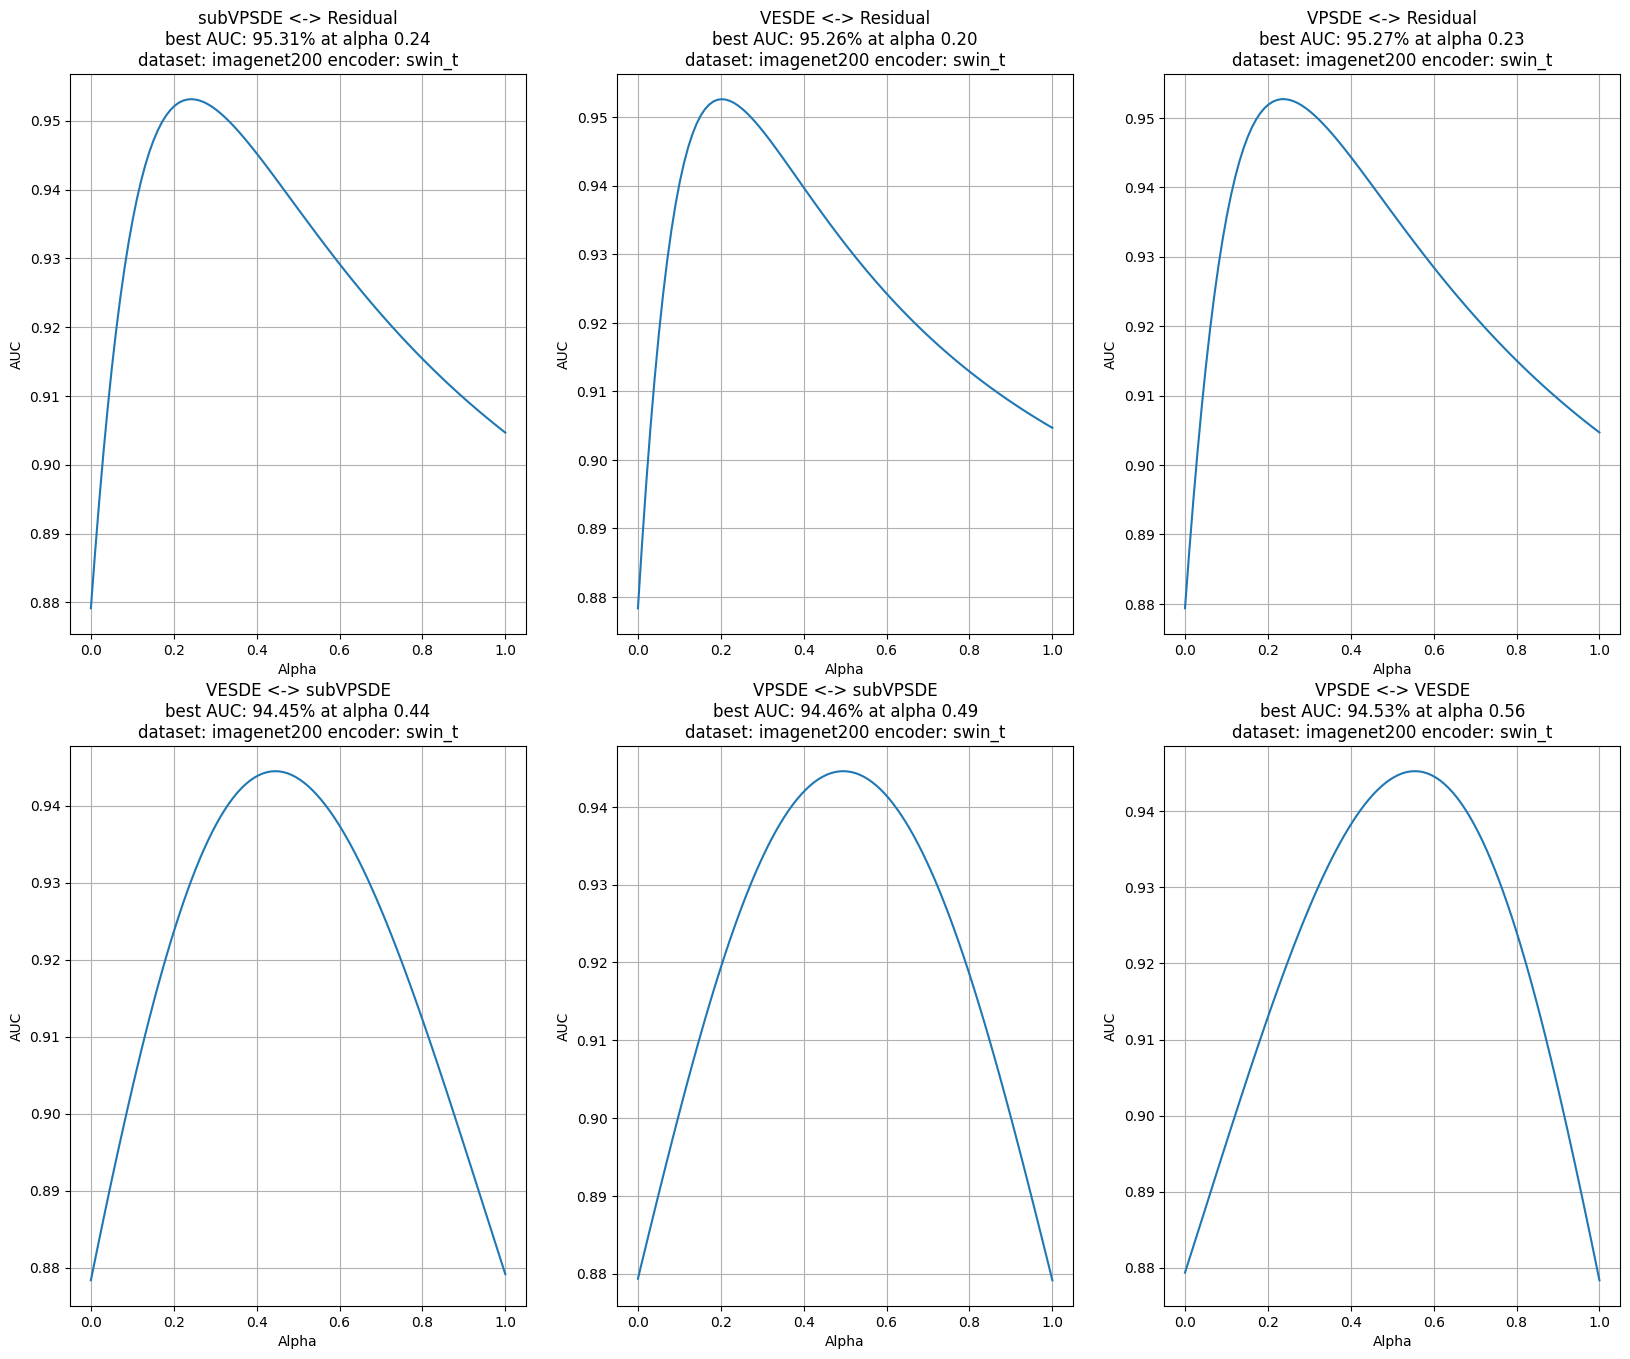

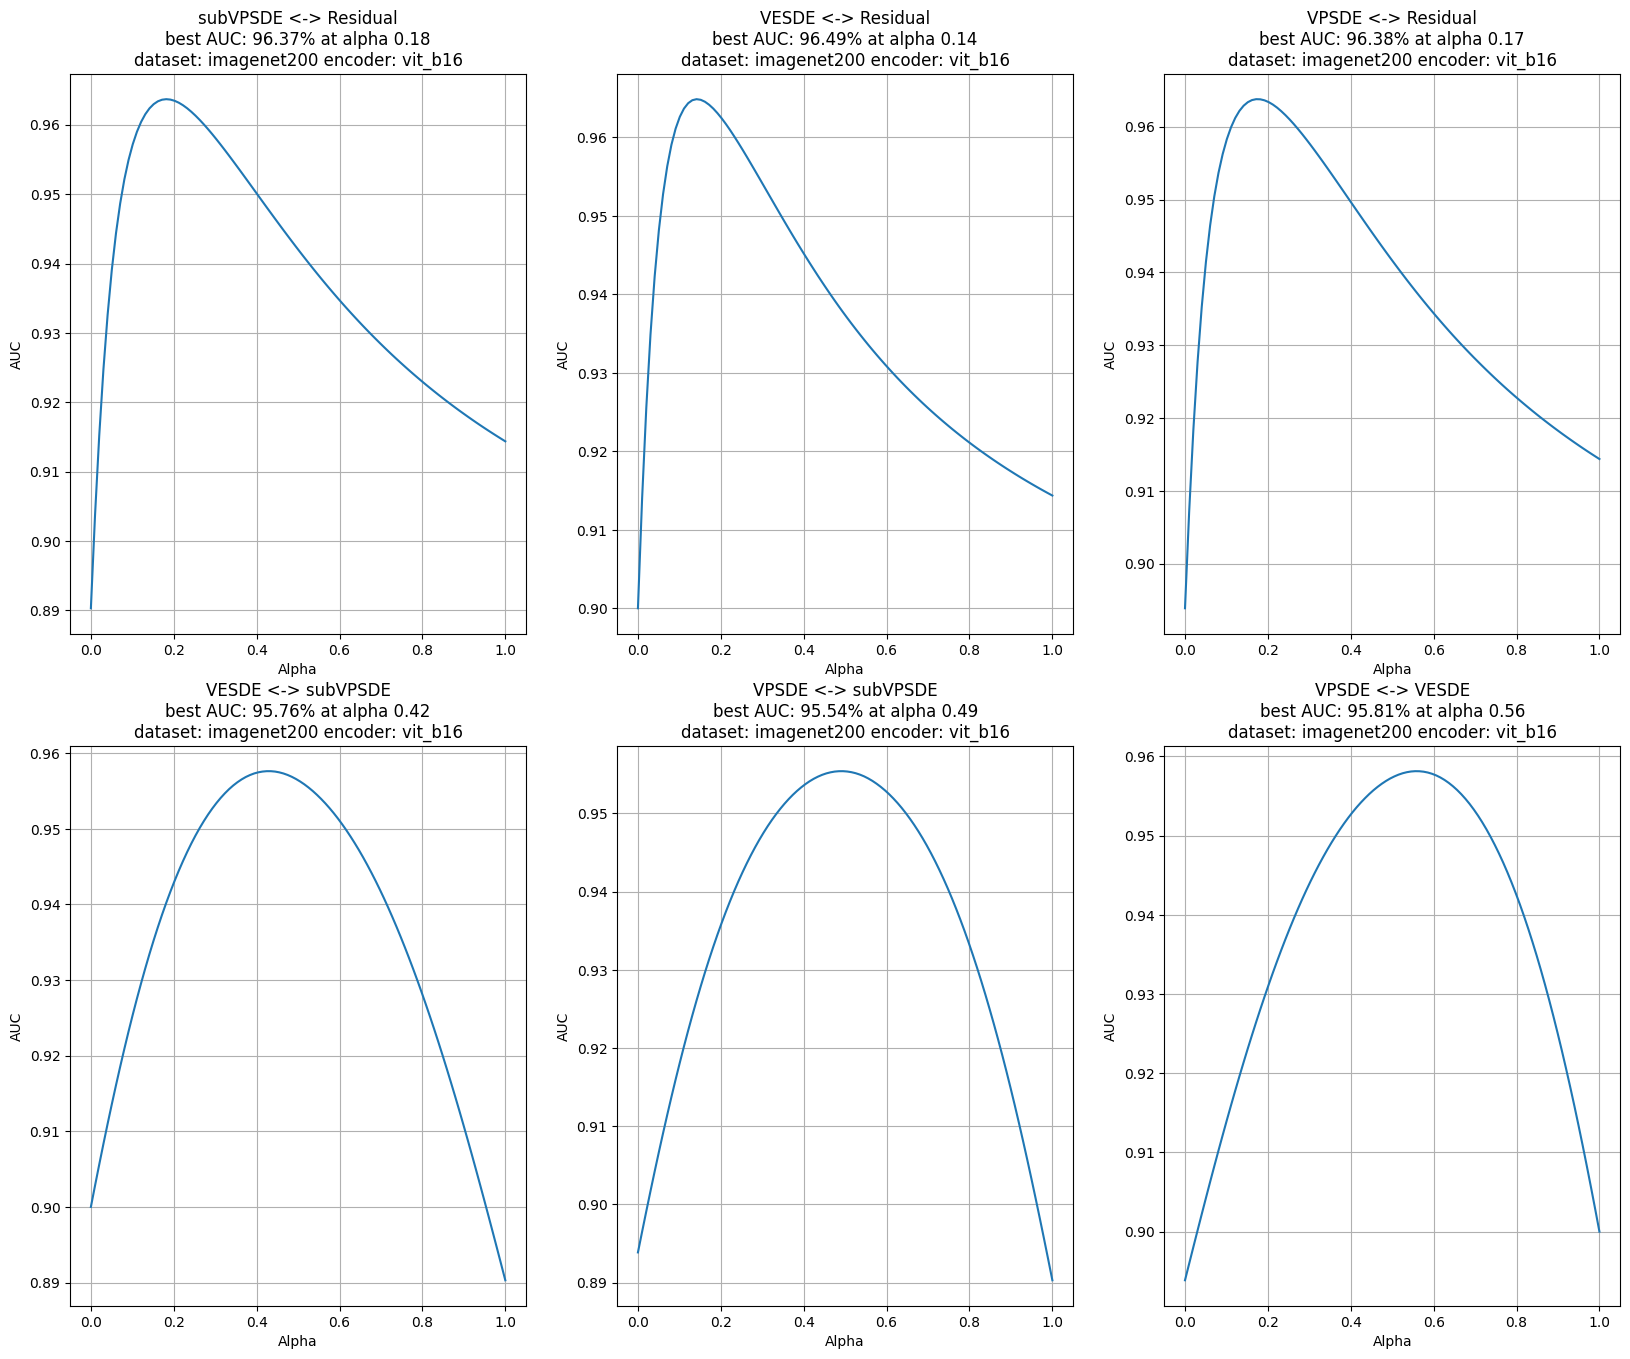

In [118]:
import matplotlib.pyplot as plt

for encoder in encoders:
    if encoder not in res_dict:
        continue
    _res_dict = res_dict[encoder]
    fig, ax = plt.subplots(2, 3, figsize=(20,16))
    ax = ax.flatten()
    for i, (select1, select2) in enumerate(_res_dict.keys()):
        res = _res_dict[(select1, select2)]
        ax[i].plot(alphas, res)
        ax[i].set_xlabel("Alpha")
        ax[i].set_ylabel("AUC")
        ax[i].set_title(f"{select2} <-> {select1}\nbest AUC: {max(res) :.2%} at alpha {alphas[np.argmax(res)]:.2f}\ndataset: {dataset} encoder: {encoder}")
        ax[i].grid()
